Contents:
- Upsampling / Transpose Convolutions
- 1D GAN

# Upsampling / Transpose Convolutions
The generator of a GAN needs to translate from coarse salient features to a more dense and detailed output (typically an image). I.e. a kind of 'inverse' to pooling layers.

NOTE: Move to cnn-basics?

references: https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/

## UpSampling2D
By default UpSampling2D uses a nearest neighbor algorithm to fill in the new rows and columns effectively duplicating points. (‘interpolation‘ argument = ‘nearest‘). Bilinear interpolation can be specified via setting the ‘interpolation‘ argument to ‘bilinear‘ e.g. UpSampling2D(interpolation='bilinear').

Subsequent convolution layers will be trained to interpret the upsampled output and translate it into meaningful detail.

In [5]:
# example of using the upsampling layer
from numpy import asarray
from keras.models import Sequential
from keras.layers import UpSampling2D

# define input data
X = asarray([[1, 2],
             [3, 4]])

# show input data for context
print(X)

# reshape input data into one sample a sample with a channel
X = X.reshape((1, 2, 2, 1))

# define model
model = Sequential()
model.add(UpSampling2D(input_shape=(2, 2, 1), size=(2,2)))

# summarize the model
model.summary()

# make a prediction with the model
yhat = model.predict(X)

# reshape output to remove channel to make printing easier
yhat = yhat.reshape((4, 4))

# summarize output
print(yhat)

[[1 2]
 [3 4]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_3 (UpSampling2 (None, 4, 4, 1)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]


## Conv2DTranspose 
Conv2DTranspose performs an inverse convolution operation and thus is similar to combining the UpSampling2D and Conv2D layers into one layer in that it simultaneously upsamples and learns how to interpret the result. This is typically preferred to UpSampling2D.

In the below, stride of (2,2) doubles the size (new values assume teh value 0), weight in the single filter is set to 1 (meaning input values are multipled by 1), bias is 0 meaning nothing is added to the inputs.

In [10]:
# example of using the transpose convolutional layer
from numpy import asarray
from keras.models import Sequential
from keras.layers import Conv2DTranspose
# define input data
X = asarray([[1, 2],
             [3, 4]])
# show input data for context
print(X)
# reshape input data into one sample a sample with a channel
X = X.reshape((1, 2, 2, 1))
# define model
model = Sequential()
model.add(Conv2DTranspose(1, (1,1), strides=(2,2), input_shape=(2, 2, 1)))
# summarize the model
model.summary()
# define weights that they do nothing
weights = [asarray([[[[1]]]]), asarray([0])]
# store the weights in the model
model.set_weights(weights)
# make a prediction with the model
yhat = model.predict(X)
# reshape output to remove channel to make printing easier
yhat = yhat.reshape((4, 4))
# summarize output
print(yhat)

[[1 2]
 [3 4]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 1)           2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
[[1. 0. 2. 0.]
 [0. 0. 0. 0.]
 [3. 0. 4. 0.]
 [0. 0. 0. 0.]]


# 1D GAN
An easy starting point is to model a simple 1D function y = f(x) as we can easily visualise the real / generated values. 

## The Function We Will Learn
As an example we might use y=2x or y= x*x

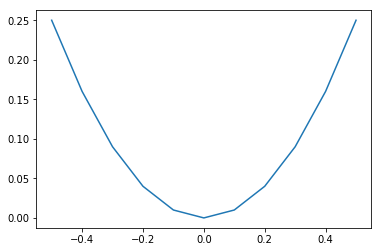

In [2]:
from matplotlib import pyplot as plt

# simple function
def calculate(x):
    return x * x

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

# calculate outputs
outputs = [calculate(x) for x in inputs]

# plot the result
plt.plot(inputs, outputs)
plt.show()

## Generate Real / Fake Data
We can sample from the above function to get values to use in our GAN. For this we create 2 functions that return real data and fake data in the correct format and with corresponging class labels.

In [18]:
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn


# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1 # X2 = calculate(X1)
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

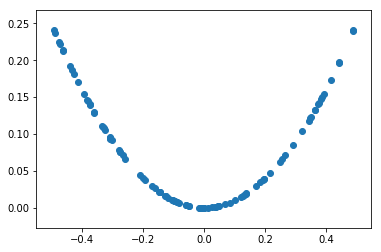

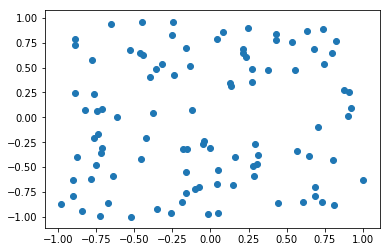

In [35]:
# plot the results
X, _ = generate_real_samples(100)
plt.scatter(X[:,0], X[:,1])
plt.show()

X, _ = generate_fake_samples(100)
plt.scatter(X[:,0], X[:,1])
plt.show()

## Create Discriminator
Next we define a discriminator model that given a vector of size 2 with input and output will return whether it is 'fake' or not. This can be used as a standalone model, although we will combine and train in the GAN.

In [47]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the discriminator model
discriminator = define_discriminator()
# summarize the model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 25)                75        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


As a test, we can try training this part of the model with both real and fake samples as it is just a normal neural network for binary classification. 

NOTE: In an actual GAN we would not train the discriminator in this way.

In [48]:
# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)

# fit the model
train_discriminator(discriminator)

0 0.59375 0.390625
1 0.53125 0.421875
2 0.5 0.34375
3 0.515625 0.390625
4 0.46875 0.453125
5 0.578125 0.375
6 0.546875 0.515625
7 0.5625 0.484375
8 0.390625 0.296875
9 0.453125 0.453125
10 0.359375 0.40625
11 0.515625 0.53125
12 0.484375 0.484375
13 0.53125 0.484375
14 0.546875 0.484375
15 0.453125 0.578125
16 0.546875 0.453125
17 0.53125 0.5625
18 0.484375 0.484375
19 0.546875 0.46875
20 0.421875 0.53125
21 0.5 0.515625
22 0.578125 0.609375
23 0.453125 0.5
24 0.5625 0.53125
25 0.4375 0.578125
26 0.5625 0.5
27 0.484375 0.640625
28 0.53125 0.4375
29 0.5 0.53125
30 0.421875 0.640625
31 0.546875 0.484375
32 0.46875 0.65625
33 0.46875 0.671875
34 0.4375 0.546875
35 0.390625 0.671875
36 0.484375 0.703125
37 0.40625 0.59375
38 0.484375 0.6875
39 0.4375 0.5625
40 0.453125 0.71875
41 0.515625 0.625
42 0.359375 0.65625
43 0.4375 0.625
44 0.453125 0.53125
45 0.46875 0.59375
46 0.421875 0.640625
47 0.453125 0.609375
48 0.515625 0.671875
49 0.375 0.578125
50 0.453125 0.640625
51 0.40625 0.6875
52 

428 0.953125 0.890625
429 0.953125 0.953125
430 0.890625 0.921875
431 0.9375 0.890625
432 0.9375 0.921875
433 0.9375 0.984375
434 0.875 0.90625
435 0.953125 0.96875
436 0.921875 0.890625
437 0.9375 0.921875
438 0.953125 0.890625
439 0.953125 0.9375
440 0.921875 0.890625
441 0.953125 0.90625
442 0.953125 0.890625
443 0.96875 0.921875
444 0.96875 0.953125
445 0.921875 0.953125
446 0.953125 0.953125
447 0.921875 0.96875
448 0.9375 0.953125
449 0.921875 0.875
450 0.9375 0.90625
451 0.984375 0.9375
452 0.921875 0.921875
453 0.96875 0.890625
454 0.890625 0.96875
455 0.984375 0.859375
456 0.953125 0.90625
457 0.921875 0.953125
458 0.9375 0.859375
459 0.90625 0.90625
460 0.9375 0.921875
461 0.96875 0.90625
462 0.890625 0.96875
463 0.953125 0.90625
464 0.90625 0.9375
465 0.890625 0.890625
466 0.90625 0.9375
467 0.984375 0.953125
468 0.9375 0.90625
469 0.953125 0.953125
470 0.96875 0.9375
471 0.953125 0.875
472 0.921875 0.875
473 0.953125 0.9375
474 0.984375 0.875
475 0.921875 0.953125
476 0.984

911 1.0 0.890625
912 1.0 0.875
913 1.0 0.96875
914 1.0 0.828125
915 1.0 0.75
916 1.0 0.890625
917 1.0 0.875
918 1.0 0.890625
919 1.0 0.84375
920 1.0 0.796875
921 1.0 0.859375
922 1.0 0.859375
923 1.0 0.890625
924 1.0 0.953125
925 1.0 0.890625
926 1.0 0.875
927 1.0 0.875
928 1.0 0.9375
929 1.0 0.859375
930 1.0 0.828125
931 1.0 0.859375
932 1.0 0.921875
933 1.0 0.84375
934 1.0 0.921875
935 1.0 0.875
936 1.0 0.9375
937 1.0 0.953125
938 1.0 0.921875
939 1.0 0.84375
940 1.0 0.828125
941 1.0 0.90625
942 1.0 0.84375
943 1.0 0.859375
944 1.0 0.8125
945 1.0 0.875
946 1.0 0.90625
947 1.0 0.90625
948 1.0 0.859375
949 1.0 0.9375
950 1.0 0.890625
951 1.0 0.90625
952 1.0 0.953125
953 1.0 0.890625
954 1.0 0.828125
955 1.0 0.921875
956 1.0 0.875
957 1.0 0.859375
958 1.0 0.921875
959 1.0 0.921875
960 1.0 0.859375
961 1.0 0.921875
962 1.0 0.875
963 1.0 0.859375
964 1.0 0.90625
965 1.0 0.890625
966 1.0 0.875
967 1.0 0.875
968 1.0 0.890625
969 1.0 0.859375
970 1.0 0.828125
971 1.0 0.890625
972 1.0 0.84375

## Create Generator
Next we define the generator model takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. x and x^2.

A latent variable is a hidden or unobserved variable, and a latent space is a multi-dimensional vector space of these variables. We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space. This is because the latent space has no meaning until the generator model starts assigning meaning to points in the space as it learns. After training, points in the latent space will correspond to points in the output space, e.g. in the space of generated samples.

We will define a small latent space of five dimensions and use the standard approach in the GAN literature of using a Gaussian distribution for each variable in the latent space. We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
Outputs: Two-element vector representing a generated sample for our function (x and x^2).

Next we define the model. Note that the model is not compiled as the generator model is not fit directly.

In [49]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# size of the latent space
latent_dim = 5
# define the generator model
generator = define_generator(latent_dim)
# summarize the model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 15)                90        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


We create a function that will generate random points in latent space, and a function that will use the generator to generate output ('fake') samples based upon random samples within the latent space as the input.

In [43]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples and plot the results
def generate_generator_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

If we run the above now, we will see a fairly random plot as the generator has not been trained. When we train it we would expect it to more closely match the real samples

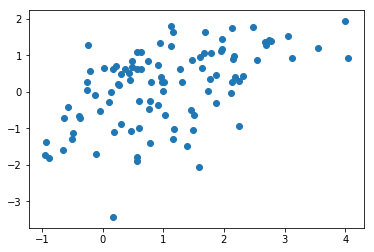

In [50]:
# generate and plot generated samples
X, _ = generate_generator_samples(generator, latent_dim, 100)

# plot the results
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## Create / Train GAN
To train the GAN model, the weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

When we define the GAN we want the discriminator to be not trainable as we can train the underlying model seperately. The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the train_on_batch() function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the train_on_batch() function. This change in the trainable property does not impact the training of standalone discriminator model.

In [51]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

Now we will train and summarise the performance. 

Generally, there are no objective ways to evaluate the performance of a GAN model so we cannot calculate any objective error score for generated output and must evaluate quality manually.

1999 0.31 0.65


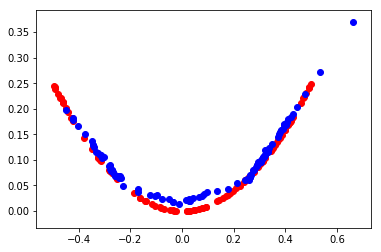

3999 0.54 0.74


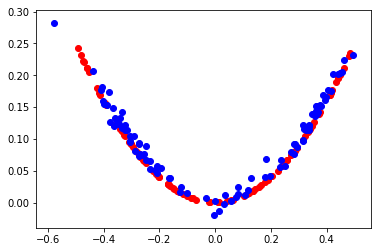

5999 0.59 0.46


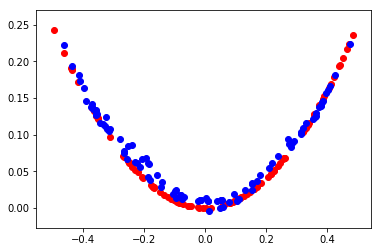

7999 0.61 0.56


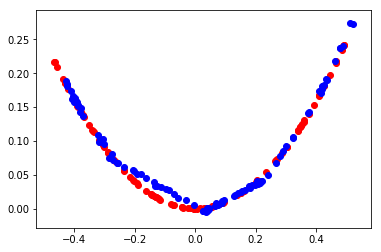

9999 0.57 0.45


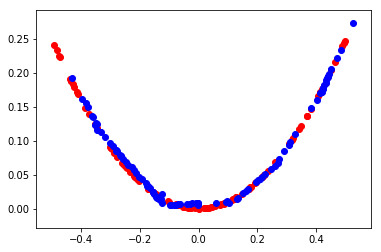

In [55]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_generator_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	plt.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_generator_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)